In [126]:
from collections import defaultdict

def indexes(l, chosen_key):
    _indices = defaultdict(list)
    for index, item in enumerate(l):
        _indices[item].append(index)

    for key, value in _indices.items():
        if key == chosen_key:
            return value
#indexes(labels, 0)

In [177]:
from mne import EpochsArray
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from scipy import signal

dataset_name = 'BrainCommand'
dataset_info = {  # BrainCommand
                    'dataset_name': 'BrainCommand',
                    '#_class': 4,
                    "target_names": ['Derecha', 'Izquierda', 'Arriba', 'Abajo'],
                    '#_channels': 8,
                    'samples': 350-50,  # 250*1.4
                    'sample_rate': 250,
                    'channels_names': ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'],  # This is from the original Unicorn cap
                    'subjects': 0,  # PENDING
                    'total_trials': 0,  # VARIABLE SINCE THE SUBJECT HAS TOTAL CONTROL OF HOW MANY MOVEMENTS THEY WANT TO DO
                    }

def data_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def remove_too_different_trials_v2(data: np.array, label) -> np.array:
    data_cleaned = []
    label_cleaned = []
    for word_index in range(len(dataset_info["target_names"])):
        indexes_from_word = indexes(label, word_index)
        for i_index in indexes_from_word:
            trial = data[i_index,:,:]
            trial_label = label[i_index]
            if np.mean(np.abs(trial)) < np.mean(np.abs(data[indexes_from_word,:,:]))*1.5 :
                data_cleaned.append(trial)
                label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def remove_too_different_trials_v1(data: np.array, label) -> np.array: #todo: decide which one is better when you get more data
    average_of_trials: int = np.mean(np.abs(data))
    data_cleaned = []
    label_cleaned = []
    for trial, trial_label in zip(data, label):
        if np.mean(np.abs(trial)) < average_of_trials*1.5 :
            data_cleaned.append(trial)
            label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def braincommand_dataset_loader(game_mode: str, subject_id: int):
    complete_information = pd.read_csv(f'assets/game_saved_files/eeg_data_{game_mode}_sub{subject_id:02d}.csv')
    x_list = list(complete_information['time'].apply(eval))
    label = list(complete_information['class'][1:])# TODO: I'm removing the first one because the EEG data is incomplete. Real time seems to have this problem too. So the first one will always be lost
    x_array = np.array(x_list[1:]) # trials, time, channels
    x_array = x_array[:, 50:, :-9] # The last channels are accelerometer (x3), gyroscope (x3), validity, battery and counter
    x_array = np.transpose(x_array, (0, 2, 1))
    x_array = signal.detrend(x_array)
    x_array, label = remove_too_different_trials_v2(x_array, label)
    x_array = data_normalization(x_array)
    return x_array, label


subject_id = 0
game_mode = 'calibration1'
event_dict = {'Arriba': 2, 'Abajo': 3, 'Derecha': 0,'Izquierda': 1}

data, labels = braincommand_dataset_loader(game_mode, subject_id)


events = np.column_stack((
    np.arange(0, dataset_info['sample_rate'] * data.shape[0], dataset_info['sample_rate']),
    np.zeros(len(labels), dtype=int),
    np.array(labels),
))

epochs = EpochsArray(data, info=mne.create_info(dataset_info['#_channels'],
                                                sfreq=dataset_info['sample_rate'], ch_types='eeg'), events=events,
                     event_id=event_dict)

Not setting metadata
157 matching events found
No baseline correction applied
0 projection items activated


In [178]:
print(len(labels))

157


In [171]:
#epochs.plot(block=True)

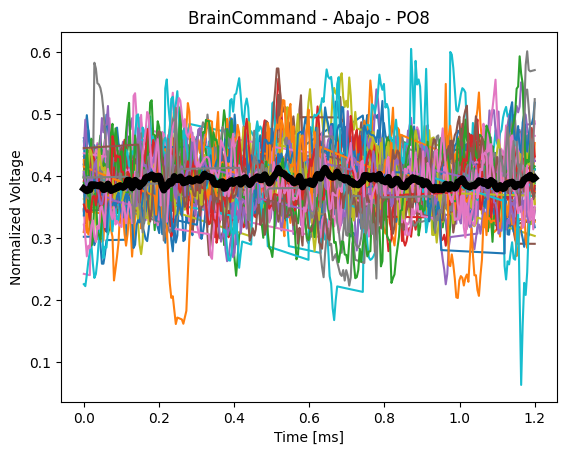

In [179]:
for channel in range(len(dataset_info["channels_names"])):
    for word_index in range(len(dataset_info["target_names"])):
        plt.clf()
        samples_to_time = np.linspace(0, dataset_info["samples"]/dataset_info["sample_rate"], num=dataset_info["samples"])
        indexes_from_word = indexes(labels, word_index)
        for i_index in indexes_from_word:
            plt.plot(samples_to_time, data[i_index,channel,:])
        plt.plot(samples_to_time, np.mean(data[indexes_from_word,channel,:], axis=0), linewidth=5, color='k')
        plt.title(f'{dataset_name} - {dataset_info["target_names"][word_index]} - {dataset_info["channels_names"][channel]}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Normalized Voltage')
        plt.savefig(f'/assets/ERP/ERP_{dataset_name}_{dataset_info["target_names"][word_index]}_{dataset_info["channels_names"][channel]}.png')

# Do the XDAWN DENOISING HERE AND SEE THE SIGNALS
https://mne.tools/stable/auto_examples/preprocessing/xdawn_denoising.html#sphx-glr-auto-examples-preprocessing-xdawn-denoising-py

In [85]:
# from mne.preprocessing import Xdawn
# from mne.viz import plot_epochs_image
# 
# plot_epochs_image(epochs)
# # Estimates signal covariance
# signal_cov = mne.compute_covariance(epochs)
# 
# # Xdawn instance
# xd = Xdawn(n_components=2, signal_cov=signal_cov)
# 
# # Fit xdawn
# xd.fit(epochs)
# 
# epochs_denoised = xd.apply(epochs)
# 
# # Plot image epoch after Xdawn
# plot_epochs_image(epochs_denoised['Arriba']) # todo: previously you should had made 'picks' and the event dict only dedicated to one event, otherwise it joins eveything

Computing rank from data with rank=None
    Using tolerance 1.6e-07 (2.2e-16 eps * 8 dim * 9.2e+07  max singular value)
    Estimated rank (eeg): 8
    EEG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 42900
[done]


C:\Users\rosit\AppData\Local\Temp\ipykernel_21576\297734112.py:2: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  signal_cov = mne.compute_covariance(epochs)


Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


Xdawn({'correct_overlap': 'auto',
 'n_components': 2,
 'reg': None,
 'signal_cov': <Covariance | size : 8 x 8, n_samples : 42899, data : [[0.02465803 0.02463604 0.02461719 0.024658   0.02465058 0.02457385
  0.02463756 0.02464417]
 [0.02463604 0.02461709 0.02460033 0.02463641 0.02463009 0.02456217
  0.02461848 0.02462439]
 [0.02461719 0.02460033 0.02458566 0.02461747 0.02461174 0.02455189
  0.02460154 0.02460675]
 [0.024658   0.02463641 0.02461747 0.02465878 0.02465126 0.02457413
  0.0246383  0.02464488]
 [0.02465058 0.02463009 0.02461174 0.02465126 0.0246446  0.02457024
  0.02463191 0.02463838]
 [0.02457385 0.02456217 0.02455189 0.02457413 0.02457024 0.02452847
  0.02456312 0.02456678]
 [0.02463756 0.02461848 0.02460154 0.0246383  0.02463191 0.02456312
  0.02462054 0.02462631]
 [0.02464417 0.02462439 0.02460675 0.02464488 0.02463838 0.02456678
  0.02462631 0.02463259]]>})